In [ ]:
# install the required packages
!pip install bioread
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tk


In [1]:
# import the necessary libraries and create functions
try:
    import bioread
    import matplotlib.pyplot as plt
    import os
    import pandas as pd
    import numpy as np
    import tkinter as tk
    from tkinter import*
    from tkinter import filedialog

    current_path = os.getcwd()
    print("All necessary libraries are installed successfully")
    print("Current working directory is: ", current_path)
except ImportError:
    print("Please install the necessary libraries using 'pip install -r requirements.txt' before running the script")
    exit(1)


def load_acq():

    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    file_path = filedialog.askopenfilename()

    if not os.path.exists(file_path):
        print('File not found')
        exit(1)


    data = bioread.read_file(file_path)
    emg_data = data.channels[0].data
    fs = data.samples_per_second

    print('file path: ', file_path)
    print('EMG data:', emg_data)
    print('EMG data type:', type(emg_data))
    print('sampling rate:', fs)


    return file_path, emg_data, fs

def plot_segment_h_m (segment_emg,sample_rate,savedir, m_latency = 0.02, h_latency_begin = 0.03, h_latency_end = 0.045):
    # M-wave calculate peak to peak amplitude after 12 miliseconds
    try:
      m_time_frame = int(m_latency*sample_rate)
      peak_to_peak_m = np.max(segment_emg[5:m_time_frame]) - np.min(segment_emg[3:m_time_frame])
    except:
      peak_to_peak_m = np.nan

    # H-reflex calculate peak to peak amplitude after between 15 and 35 miliseconds
    try:
      h_time_frame = int(h_latency_begin*sample_rate)
      h_time_frame_end = int(h_latency_end *sample_rate)
      peak_to_peak_h = np.max(segment_emg[h_time_frame:h_time_frame_end]) - np.min(segment_emg[h_time_frame:h_time_frame_end])
    except:
      peak_to_peak_h = np.nan

    plt.plot(segment_emg)
    plt.axvline(x=5, linestyle = 'dashed', label = 'start M-wave')
    plt.axvline(x=m_time_frame, linestyle = 'dashed', label = 'end M-wave')
    plt.axvline(x=h_time_frame, linestyle = 'dashed', label = 'start H-reflex')
    plt.axvline(x=h_time_frame_end, linestyle = 'dashed', label = 'end H-reflex')

    plt.savefig(savedir)
    plt.close()

    return peak_to_peak_m, peak_to_peak_h

def split_and_save_to_csv(data, sample_rate, filename_base, chunk_size_seconds=10, above_threshold = 0.25, min_percent_change_per_stim = 0.05):
  """
  Splits a NumPy ndarray (data) into sections of specified size (chunk_size_seconds)
  based on the sample rate and saves them as separate CSV files with an incremental base filename.
  For each chunk, it finds the first peak above a threshold and all peak frames, storing them in a list.

  Args:
      data: The NumPy ndarray to be split.
      sample_rate: The sampling rate of the data in Hz.
      filename_base: The base filename for the output CSV files (e.g., "my_data_").
      chunk_size_seconds: The size of each chunk in seconds (default: 10).

  Returns:
      A list of lists, where each inner list contains peak frames for a corresponding chunk.
  """
  # Create save folder
  if not os.path.exists(os.path.dirname(filename_base)):
    os.makedirs(os.path.dirname(filename_base))

  # if min_percent_change_per_stim < 0 or min_percent_change_per_stim > 1:
  #   raise ValueError("min_percent_increase_per_stim must be between 0 and 1")


  # Calculate chunk size in samples
  chunk_size_samples = int(chunk_size_seconds * sample_rate)

  # Split the data into chunks
  chunks = np.array_split(data, len(data) // chunk_size_samples)

  # List to store peak frames for each chunk
  peak_frames_list = []
  count = 0
  # Save each chunk and find peaks
  for i, chunk in enumerate(chunks):

    # Calculate threshold based on first 0.5 seconds (assuming integer sample rate)
    half_second_samples = int(sample_rate * 0.5)
    average_first_half = np.mean(chunk[:half_second_samples])
    threshold = average_first_half + above_threshold * np.abs(average_first_half)  # Adjust factor as needed

    # Find peaks
    peaks = []
    for j in range(1, len(chunk) - 1):  # Avoid first and last element for peak detection
      if chunk[j] > threshold and chunk[j] > chunk[j - 1] and chunk[j] > chunk[j + 1]:

        # Store frame index of the peak
        peaks.append(j)

        # Only store the first peak if desired (modify condition)
        if len(peaks) == 1:
          count += 1
          filename = f"{filename_base}{count}.csv"
          ms_to_add = 50
          add_frames = int(ms_to_add/1000*sample_rate)+2
          chunk_cropped = chunk[peaks[0]-2:peaks[0]+add_frames]

          csv_file_to_save = filename.replace('.csv','.png')
          peak_to_peak_m, peak_to_peak_h = plot_segment_h_m (chunk_cropped,sample_rate,csv_file_to_save)
          # do not save if the peak to peak values differ more than X% from the previous peak to peak values
          if len(peak_frames_list) > 0: # check if the stim is the second
            is_h_too_diff = abs((1 - peak_to_peak_h / peak_frames_list[-1]["peak_to_peak_h"])) > min_percent_change_per_stim
            is_m_too_diff = abs((1 - peak_to_peak_m / peak_frames_list[-1]["peak_to_peak_m"])) > min_percent_change_per_stim
            if is_h_too_diff and is_m_too_diff:
              os.remove(csv_file_to_save)
              continue
            elif is_h_too_diff:
              peak_to_peak_h = np.nan
            elif is_m_too_diff:
              peak_to_peak_m = np.nan
              

          # Save the cropped chunk to a CSV file and store peak frames
          np.savetxt(filename, chunk_cropped, delimiter=",")  # Use "," as delimiter by default
          peak_frames_list.append({"filename": os.path.basename(filename), "threshold": threshold, "peak_frame": peaks,
                                   "peak_to_peak_m": peak_to_peak_m, "peak_to_peak_h": peak_to_peak_h})

          break

  peak_frames_df = pd.DataFrame(peak_frames_list)
  return peak_frames_df

print("Libraries and functions loaded")

All necessary libraries are installed successfully
Current working directory is:  c:\Git\msk_modelling_python\src\neuro
Libraries and functions loaded


In [12]:
# Load data and print some information
import sys
file_path, emg_data, fs = load_acq()
if emg_data is None or fs is None:
    print('Error loading data')
    sys.exit(1) 

file_name_no_ext = os.path.splitext(os.path.basename(file_path))[0]
save_path = os.path.join(os.path.dirname(file_path), file_name_no_ext + '_splits',"data_segments_")

seconds_per_chunk = 1.5
peak_frames_per_chunk = split_and_save_to_csv(emg_data, fs, save_path, chunk_size_seconds=seconds_per_chunk, 
                                              above_threshold = 0.05, min_percent_change_per_stim = 1)

# save the peak frames per chunk to a csv file
peak_frames_per_chunk.to_csv(os.path.join(os.path.dirname(save_path),"peak_frames_per_chunk.csv"), index=False)
print('save data in:' , os.path.dirname(file_path))
print('N of peaks found:' , len(peak_frames_per_chunk))

file path:  C:/Users/Bas/ucloud/BSc_thesis_S2024/Lukas_Weilharter/data/session11/RC11_2.acq
EMG data: [-0.36010742 -0.35858154 -0.35858154 ... -1.18408203 -1.18408203
 -1.18560791]
EMG data type: <class 'numpy.ndarray'>
sampling rate: 1000.0
save data in: C:/Users/Bas/ucloud/BSc_thesis_S2024/Lukas_Weilharter/data/session11
N of peaks found: 271


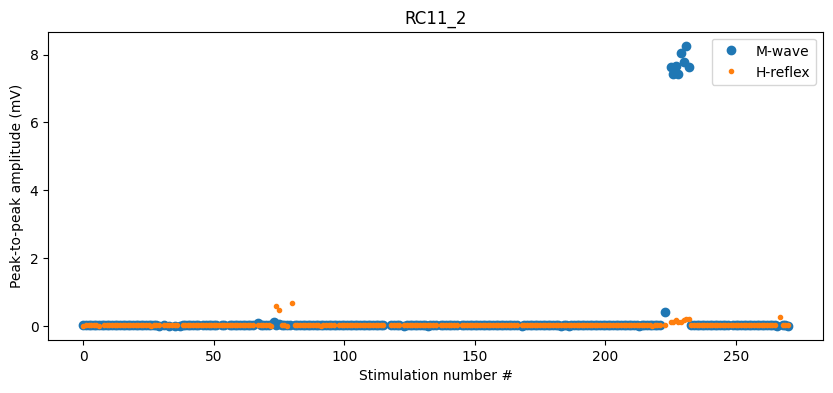

In [13]:
# Plot average every X frames
m = peak_frames_per_chunk["peak_to_peak_m"].rolling(1).mean()
h = peak_frames_per_chunk["peak_to_peak_h"].rolling(1).mean()
x = np.arange(len(m))

# plotting peak frames
plt.figure(figsize=(10, 4))
plt.plot(x,m,marker='o', linestyle='None')
plt.plot(x,h,marker='.', linestyle='None')
plt.legend(["M-wave", "H-reflex"])
plt.xlabel("Stimulation number #")
plt.ylabel("Peak-to-peak amplitude (mV)")
plt.title(file_name_no_ext)
plt.savefig(file_path.replace('.acq','_RC.png'))